## Exploratory Data Analysis

This section is to explore the data, in terms of its attributes and properties, to determine areas of further analysis.

Some data dimensions and distribution break-downs will be displayed in this section as well.










In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import range_unit_root_test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [ ]:
pd.reset_option("max_columns")
pd.reset_option("max_rows")
pd.reset_option("max_colwidth")

In [ ]:
pd.set_option('display.max_columns', None)

Read the data file (you should have it saved somewhere already. Rename it to airtraffic.csv or simply change the code cell below.

In [ ]:
data = pd.read_csv("./airtraffic.csv", header=0)

In [ ]:
data.columns = [
    "activity_period", "start_date", "airline", "operating_code",
    "published_airline", "published_code","geo", "region", "activity_code",
    "price_category", "terminal", "boarding_area", "passengers",
    "data_as_of", "data_load_time"
]

In [ ]:
# statistics: avg, total
# number of instances of data: count
# dimensions
# check for NA values
# data types: discrete vs continuous

In [ ]:
def understand_df(data):

    # Dimensions of dataset
    print(f"The dimension in the original data is {data.shape} \n")

    # Head of dataset
    print("First 10 rows of the dataset are \n", data.head(10), "\n\n")

    # Summary of dataset
    print("Summary of the dataset is \n", data.describe(), "\n\n")

    # Stats of dataset
    stats = []
    for col in data.columns:
        stats.append((col, data[col].nunique(), data[col].isnull().sum() * 100 / data.shape[0], data[col].value_counts(normalize=True, dropna=False).values[0] * 100, data[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
    print("Statistics of the dataset are \n", stats_df.sort_values('Percentage of missing values', ascending=False), "\n\n")

Run the following cell:

In [ ]:
understand_df(data)

The dimension in the original data is (35172, 15) 

First 10 rows of the dataset are 
    activity_period  start_date                                  airline  \
0           199907  1999/07/01                             ATA Airlines   
1           199907  1999/07/01                             ATA Airlines   
2           199907  1999/07/01                             ATA Airlines   
3           199907  1999/07/01  Aeroflot Russian International Airlines   
4           199907  1999/07/01  Aeroflot Russian International Airlines   
5           199907  1999/07/01                               Air Canada   
6           199907  1999/07/01                               Air Canada   
7           199907  1999/07/01                                Air China   
8           199907  1999/07/01                                Air China   
9           199907  1999/07/01                               Air Europe   

  operating_code                        published_airline published_code  \
0          

In [ ]:
#breakdown = pd.DataFrame(data.time.value_counts())
#breakdown
data['yy-mm'] = pd.to_datetime(data['start_date']).dt.strftime('%Y-%m')
data['year'] = pd.to_datetime(data['start_date']).dt.strftime('%Y')
data['month'] = pd.to_datetime(data['start_date']).dt.strftime('%m')

In [ ]:
data['passengers'] = data['passengers'].str.replace(',', '')

In [ ]:
data.dtypes

activity_period       int64
start_date           object
airline              object
operating_code       object
published_airline    object
published_code       object
geo                  object
region               object
activity_code        object
price_category       object
terminal             object
boarding_area        object
passengers           object
data_as_of           object
data_load_time       object
yy-mm                object
year                 object
month                object
dtype: object

Can you tell what might be "off" from the above?

In [ ]:
data = data.astype({"passengers": "float32",
             "year": "int32",
             "month": "int32"
             })
# in order for this to work

In [ ]:
data.passengers.describe()

count     35172.000000
mean      28000.507812
std       62772.761719
min           0.000000
25%        4452.000000
50%        8634.000000
75%       19893.750000
max      856501.000000
Name: passengers, dtype: float64

The general description of monthly passenger count is:
1. Mean is roughly 28000
2. Standard deviation is roughly 62772
3. 25th percentile and 75th percentile are 4452 and 19893
4. Median is roughly 8634
5. Max and min are 0 and 856501

NOTE: passenger count is on a monthly basis.

In [ ]:
# Plotting can be repetitive. Here's a function that automates the process.

def plot_time_series(df, x, y, title, xlabel, ylabel, compare=False, y2=None, ylabel2=None, color="blue", figsize=False):
    if figsize is True:
      f, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    else:
      f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
    sns.lineplot(data=df, x=df[x], y=df[y], color=color, ax=ax)

    # For comparisons:
    if compare == True:
      plt.plot(df[y2], label=ylabel2, color = 'red')
      plt.title("Actual vs Predicted Plane Ticket Interest over Time")
    else:
      plt.title(title)
    plt.xlabel(xlabel)
    plt.legend()
    plt.ylabel(ylabel)
    plt.rc({'font.size': 16})
    plt.tight_layout()
    plt.show()

In [ ]:
data.columns

Index(['activity_period', 'start_date', 'airline', 'operating_code',
       'published_airline', 'published_code', 'geo', 'region', 'activity_code',
       'price_category', 'terminal', 'boarding_area', 'passengers',
       'data_as_of', 'data_load_time', 'yy-mm', 'year', 'month'],
      dtype='object')

#### By Year

#### Overall

In [ ]:
data["index"] = data.index

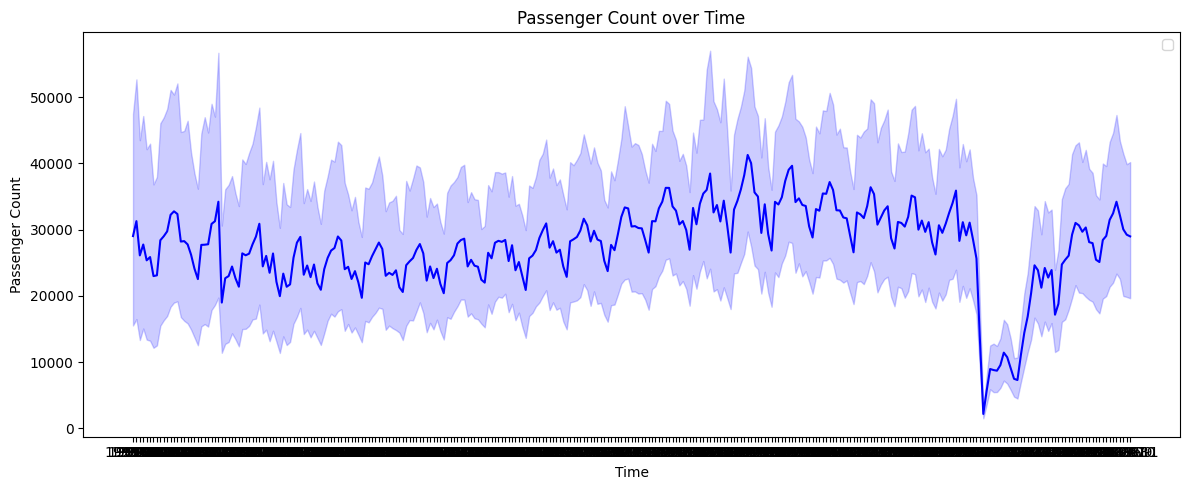

In [ ]:
plot_time_series(df=data, x="yy-mm", y="passengers",
                 title="Passenger Count over Time",
                 xlabel="Time", ylabel="Passenger Count", figsize=(24, 8))

Why is there a range of values?
It could be that data collection took place multiple times a day so we need a method to account for the difference.

## Data Filtering and Breakdowns

#### More breakdowns by airlines and months

In [ ]:
airmonth = pd.DataFrame(data.groupby(["airline", "yy-mm"], as_index=False).agg({'passengers': [np.sum, np.mean]}))

In [ ]:
airmonth.columns = ["airline", "yy-mm", "total_passengers", "avg_passengers"]
airmonth.head()

airline    yy-mm  total_passengers  \
0  ABC Aerolineas S.A. de C.V. dba Interjet  2018-03            2302.0   
1  ABC Aerolineas S.A. de C.V. dba Interjet  2018-04            4083.0   
2  ABC Aerolineas S.A. de C.V. dba Interjet  2018-05            3846.0   
3  ABC Aerolineas S.A. de C.V. dba Interjet  2018-06            5354.0   
4  ABC Aerolineas S.A. de C.V. dba Interjet  2018-07            4911.0   

   avg_passengers  
0          1151.0  
1          2041.5  
2          1923.0  
3          2677.0  
4          2455.5

Are there a different columns (variables) to use groupby and the agg function? write below.

It's useful to print out data.columns to see what's going on.

As an example, I did

In [ ]:
some = pd.DataFrame(data.groupby(["airline", "yy-mm"]).agg({'passengers': [np.sum, np.mean]})).reset_index()
some.columns = ["airline", "yy-mm", "total_passengers", "avg_passengers"]
some.head()

airline    yy-mm  total_passengers  \
0  ABC Aerolineas S.A. de C.V. dba Interjet  2018-03            2302.0   
1  ABC Aerolineas S.A. de C.V. dba Interjet  2018-04            4083.0   
2  ABC Aerolineas S.A. de C.V. dba Interjet  2018-05            3846.0   
3  ABC Aerolineas S.A. de C.V. dba Interjet  2018-06            5354.0   
4  ABC Aerolineas S.A. de C.V. dba Interjet  2018-07            4911.0   

   avg_passengers  
0          1151.0  
1          2041.5  
2          1923.0  
3          2677.0  
4          2455.5

In [ ]:
comprehensive = pd.DataFrame(data.groupby(["airline", "yy-mm", "geo", "region", "price_category"]).agg({'passengers': [np.sum, np.mean]})).reset_index()
comprehensive.columns = ["airline", "yy-mm", "geo", "region", "price_category", "total_passengers", "avg_passengers"]
comprehensive.head()

airline    yy-mm            geo  region  \
0  ABC Aerolineas S.A. de C.V. dba Interjet  2018-03  International  Mexico   
1  ABC Aerolineas S.A. de C.V. dba Interjet  2018-04  International  Mexico   
2  ABC Aerolineas S.A. de C.V. dba Interjet  2018-05  International  Mexico   
3  ABC Aerolineas S.A. de C.V. dba Interjet  2018-06  International  Mexico   
4  ABC Aerolineas S.A. de C.V. dba Interjet  2018-07  International  Mexico   

  price_category  total_passengers  avg_passengers  
0          Other            2302.0          1151.0  
1          Other            4083.0          2041.5  
2          Other            3846.0          1923.0  
3          Other            5354.0          2677.0  
4          Other            4911.0          2455.5

#### Track our many new DataFrames!!

Use a different visualization tool Plotly for a more interactive design.

If you would like to stick to matplotlib or seaborn, feel free to do so

In [ ]:
airmonth["year"] = airmonth["yy-mm"].apply(lambda x: x.split("-")[0])
airmonth["month"] = airmonth["yy-mm"].apply(lambda x: x.split("-")[1])

Do the same for your own dataframe

Visit

https://plotly.com/python/styling-plotly-express/#builtin-plotly-express-styling-arguments

Run the plot_time_series function above

Did it work?

If yes, horray~

If not, why that might be?

Explore the function. Try using Plotly's px.line (google it)

In [ ]:
for x in airmonth.airline.unique():
  fig = px.box(airmonth[airmonth["airline"]==x], x="year", y="total_passengers", title=f"{x}: Total Passengers",
               width=1000, height=700)
  fig.show()

What patterns did you see?

(# type your response here)

How might you change the for-loop from above? Would it benefit from an additional differentiator like color?

Copy and paste the code for your visualizations from last week. Be sure to change the variable names as necessary.

1. Try writing a for-loop for your visualization, if applicable.
2. If not, how might you capture more info into the same plot?
3. If you feel the plot looks busy, how might you break it down?
4. Is the visualization simple, intuitive, and important to airlines and the SF airport?

Write a short paragraph about your findings.

1. Did something surprise you? Why or why not?

2. What can be said about 2020?

3. What are recent trends (2021-2023)?

4. What about overall patterns (without considering time)?

Analyze the following function:

In [ ]:
def plot_treemaps(data, yr, column_list, by):
  df = data.query(f"year=={yr}")
  fig = px.treemap(df, path=[px.Constant("All")]+column_list, values='passengers',
                   color='passengers', hover_data=[by], color_continuous_scale='RdBu')
  fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
  fig.show()

In [ ]:
plot_treemaps(data, 2020, ['geo', 'region', 'airline'], 'region')

Try previous years

What other columns / variables would you use plot_treemaps() to explore?

Don't like treemaps? What other plots can you use to explore the same kind of info?

As an example:

In [ ]:
plot_treemaps(data, 2020, ['month', 'activity_code', 'price_category'], 'price_category')

Look into the below function

In [ ]:
fig = px.density_heatmap(data, x="activity_code", y="price_category", template="seaborn",
                         marginal_x="histogram", marginal_y="histogram", width=800, height=700)
fig.show()

What did you discover?

Explore at least 1 other way to use the above function.

Google px.density_heatmap()


In [ ]:
comprehensive.head()

airline    yy-mm            geo  region  \
0  ABC Aerolineas S.A. de C.V. dba Interjet  2018-03  International  Mexico   
1  ABC Aerolineas S.A. de C.V. dba Interjet  2018-04  International  Mexico   
2  ABC Aerolineas S.A. de C.V. dba Interjet  2018-05  International  Mexico   
3  ABC Aerolineas S.A. de C.V. dba Interjet  2018-06  International  Mexico   
4  ABC Aerolineas S.A. de C.V. dba Interjet  2018-07  International  Mexico   

  price_category  total_passengers  avg_passengers  
0          Other            2302.0          1151.0  
1          Other            4083.0          2041.5  
2          Other            3846.0          1923.0  
3          Other            5354.0          2677.0  
4          Other            4911.0          2455.5

In [ ]:
data.columns

Index(['activity_period', 'start_date', 'airline', 'operating_code',
       'published_airline', 'published_code', 'geo', 'region', 'activity_code',
       'price_category', 'terminal', 'boarding_area', 'passengers',
       'data_as_of', 'data_load_time', 'yy-mm', 'year', 'month', 'index'],
      dtype='object')

In [32]:
final_df = data\
                .groupby(["yy-mm", "airline", "price_category", "geo", "region", "activity_code", "operating_code", "terminal", "boarding_area"])\
                ['passengers']\
                .agg(['sum'])\
                .rename(columns=lambda colname: str(colname)+'_passengers')\
                .reset_index()

In [ ]:
fig = px.histogram(comprehensive, y="airline", x="total_passengers", color="price_category",
                   title="Total Passengers by Airline and Pricing", template="plotly",
                   width=1250, height=700)
fig.show()

What other ways might you use the barplot for?


In [ ]:
comprehensive["year"] = comprehensive["yy-mm"].apply(lambda x: x.split("-")[0])
comprehensive["month"] = comprehensive["yy-mm"].apply(lambda x: x.split("-")[1])

In [ ]:
fig = px.histogram(comprehensive, x="month", y="total_passengers", color="geo")
#fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

What about year?

What about month?





In [ ]:
fig = px.scatter(some, x="yy-mm", y="avg_passengers",
                 size="total_passengers", color="airline", hover_name="airline", width=1000, height=750)
fig.show()

In [ ]:
fig = px.scatter(some.query("airline=='United Airlines - Pre 07/01/2013'"), x="yy-mm", y="avg_passengers",
                 size="total_passengers", width=1000, height=750)
fig.show()

In [ ]:
fig = px.scatter(some.query("airline=='United Airlines'"), x="yy-mm", y="total_passengers",
                 width=1000, height=750)
fig.show()

In [ ]:
fig = px.scatter(data.query("airline=='United Airlines'"), x="yy-mm", y="passengers", color="region",
                 width=1000, height=750)
fig.show()

In [ ]:
fig = px.scatter(final_df.query("airline=='United Airlines' & region=='US'"), x="yy-mm", y="sum_passengers", color="activity_code",
                 width=1000, height=750)
fig.show()

In [ ]:
fig = px.scatter(final_df.query("airline=='United Airlines' & region=='US' & activity_code=='Enplaned'"), x="yy-mm", y="sum_passengers", color="terminal",
                 width=1000, height=750)
fig.show()

In [ ]:
fig = px.scatter(final_df.query("airline=='United Airlines' & region=='US' & activity_code=='Deplaned' & terminal=='Terminal 3'"), x="yy-mm", y="sum_passengers", color="boarding_area",
                 width=1000, height=750)
fig.show()

In [ ]:
fig = px.scatter(data.query("airline=='United Airlines' or airline=='United Airlines - Pre 07/01/2013' & region=='US' & activity_code=='Enplaned' & terminal=='Terminal 3' & boarding_area=='F'"), x="yy-mm", y="passengers", color="month",
                 width=1000, height=750)
fig.show()

In [ ]:
fig = px.scatter(data.query("airline=='United Airlines'"), x="yy-mm", y="passengers", color="month",
                 width=1000, height=750)
fig.show()

In [39]:
fig = px.scatter(data.query("airline=='United Airlines - Pre 07/01/2013'"), x="yy-mm", y="passengers", color="month",
                 width=1000, height=750)
fig.show()

There's something "wrong" with United Airlines. Can you spot this?

Between April 2012 and April 2020 is the problematic period: it has a cumulative sum (additive effect) instead.

And then again, from 2020 onward, data becomes additive or cumulative.

The variables and unique values involved are:
1. activity_code: Deplaned, Enplaned
2. terminal: Terminal 3
3. boarding_area: E, F

Solution?

It's unclear how they recorded the data in the first place. If you serach up the data source, all they tell us is that some fields are additive. But that's not informative. How did they sum up previous passenger counts? Why are the numbers so large?

In [33]:
cols = ["activity_code", "terminal", "boarding_area"]

activity_code = ["Deplaned", "Enplaned"]
terminal = ["Terminal 3"]
boarding_area = ["E", "F"]

combinations = []
# don't use the zip() method, which only does element by position, not all combinations
for a in activity_code:
  for b in boarding_area:
    combinations.append([a, "Terminal 3", b])
combinations

[['Deplaned', 'Terminal 3', 'E'],
 ['Deplaned', 'Terminal 3', 'F'],
 ['Enplaned', 'Terminal 3', 'E'],
 ['Enplaned', 'Terminal 3', 'F']]

In [ ]:
df.query("airline=='United Airlines' & region=='US' & activity_code=='Enplaned' & terminal=='Terminal 3' & boarding_area=='E'")[["yy-mm","passengers"]]

yy-mm  passengers
19766  2014-01     18600.0
19882  2014-02    213908.0
19996  2014-03    248037.0
20107  2014-04    256717.0
20220  2014-05    263538.0
...        ...         ...
34555  2023-07    222787.0
34699  2023-08    224638.0
34847  2023-09    213144.0
34995  2023-10    239479.0
35140  2023-11    222361.0

[119 rows x 2 columns]

After some experimentation, I found that np.log10(x)*10 works well here, preserving the overall pattern while also scaling down the large values.

In [34]:
for c in combinations:
  # unpack into 3 objects
  x,y,z = c
  #
  data.loc[(data["airline"]== "United Airlines") & (data["activity_period"] >= 201204)\
           & (data["geo"]== "Domestic") & (data["activity_period"] < 202004)\
           & (data["activity_code"]==x) & (data["terminal"]==y)\
           & (data["boarding_area"]==z) & (data["region"]== "US"), ["passengers"]]\
           = data.loc[(data["airline"]== "United Airlines") & (data["activity_period"] >= 201204)\
           & (data["geo"]== "Domestic") & (data["activity_period"] < 202004)\
           & (data["activity_code"]==x) & (data["terminal"]==y)\
           & (data["boarding_area"]==z) & (data["region"]== "US"), ["passengers"]].apply(lambda x: np.log10(x)*10)

In [35]:
data.query("airline=='United Airlines' & region=='US' & activity_code=='Enplaned' & terminal=='Terminal 3' & boarding_area=='F'")[["yy-mm","passengers"]]

yy-mm  passengers
16094  2011-05     53997.0
16212  2011-06     81444.0
16330  2011-07     83440.0
16448  2011-08     88975.0
16565  2011-09     81028.0
...        ...         ...
34558  2023-07    511040.0
34702  2023-08    476264.0
34850  2023-09    415740.0
34998  2023-10    433952.0
35143  2023-11    415933.0

[151 rows x 2 columns]

In [45]:
fig = px.scatter(data.query("airline=='United Airlines - Pre 07/01/2013' & region=='US'"), x="yy-mm", y="passengers", color="activity_code",
                 width=1000, height=750)
fig.show()

In [43]:
fig = px.scatter(data.query("airline=='United Airlines - Pre 07/01/2013' & region=='US' & activity_code=='Enplaned'"), x="yy-mm", y="passengers", color="terminal",
                 width=1000, height=750)
fig.show()

In [40]:
fig = px.scatter(data.query("airline=='United Airlines - Pre 07/01/2013' & region=='US' & activity_code=='Enplaned' & terminal=='Terminal 3'"), x="yy-mm", y="passengers", color="boarding_area",
                 width=1000, height=750)
fig.show()


In [50]:
final_df.columns

Index(['yy-mm', 'airline', 'price_category', 'geo', 'region', 'activity_code',
       'operating_code', 'terminal', 'boarding_area', 'sum_passengers'],
      dtype='object')

In [52]:
fig = px.scatter(data.query("airline=='United Airlines - Pre 07/01/2013' & region=='US' & activity_code=='Enplaned' & terminal=='Terminal 3' & boarding_area=='E'"), x="yy-mm", y="passengers",
                 color="price_category", width=1000, height=750)
fig.show()

In [54]:
fig = px.scatter(data.query("airline=='United Airlines - Pre 07/01/2013' & price_category =='Other' & region=='US' & activity_code=='Enplaned' & terminal=='Terminal 3' & boarding_area=='E'"), x="yy-mm", y="passengers",
                 width=1000, height=750)
fig.show()

In [56]:
def return_combinations(col1, col2):
  combinations = []
  for a in col1:
    for b in col2:
      combinations.append([a, b])
  return combinations

In [58]:
cols = ["activity_code", "terminal", "boarding_area"]

activity_code = ["Deplaned", "Enplaned"]
price_category = ["Other", "Low Fare"]

terminal = "Terminal 3"
boarding_area = "F"

combinations = return_combinations(activity_code, price_category)
for i,c in enumerate(combinations):
  combinations[i] = c + [terminal, boarding_area]
combinations

[['Deplaned', 'Other', 'Terminal 3', 'F'],
 ['Deplaned', 'Low Fare', 'Terminal 3', 'F'],
 ['Enplaned', 'Other', 'Terminal 3', 'F'],
 ['Enplaned', 'Low Fare', 'Terminal 3', 'F']]

In [59]:
for c in combinations:
  # unpack into 3 objects
  x,y,z,k = c
  #
  data.loc[(data["airline"]== "United Airlines - Pre 07/01/2013")\
           & (data["geo"]== "Domestic")\
           & (data["activity_code"]==x) & (data["price_category"]==y) & (data["terminal"]==z)\
           & (data["boarding_area"]==k) & (data["region"]== "US"), ["passengers"]]\
           = data.loc[(data["airline"]== "United Airlines - Pre 07/01/2013")\
           & (data["geo"]== "Domestic")\
           & (data["activity_code"]==x) & (data["price_category"]==y) & (data["terminal"]==z)\
           & (data["boarding_area"]==k) & (data["region"]== "US"), ["passengers"]].apply(lambda x: np.log10(x)*10)

Do the same for Alaska Airlines, American Airlines, Delta Air Lines, Skywest Airlines, and Southwest Airlines.

Not all will likley show these inconsistencies, but a good portion of them will, for some combinations of variables.

Another way to feature engineer is to use the `.apply()` method. Investigate into Python's `lambda` as well.



In [ ]:
# the y-axis is about the average passenger count, which is handy in that it gives us the ability to plot this graph
# The real deal is total passenger count, which we used for our size element.

fig = px.scatter(comprehensive.query("price_category=='Other'"), x="yy-mm", y="avg_passengers",
                 size="total_passengers", color="airline", hover_name="airline", width=1000, height=750)
fig.show()

The above is one way I tried to manipulate size and color.

For your visualizations, does it make sense to use size, color, both, or neither? Why?

Experiment. Feel free to change the function above based on what you see fit.

## Feature Engineering

Feature engineering is the process of using domain and statistical knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. Feature engineering can be considered as applied machine learning itself.

In [36]:
data.columns

Index(['activity_period', 'start_date', 'airline', 'operating_code',
       'published_airline', 'published_code', 'geo', 'region', 'activity_code',
       'price_category', 'terminal', 'boarding_area', 'passengers',
       'data_as_of', 'data_load_time', 'yy-mm', 'year', 'month', 'index'],
      dtype='object')

In [42]:
!pip install missingno

Fill NULL values

In [60]:
import missingno as msno

In [64]:
data.columns

Index(['activity_period', 'start_date', 'airline', 'operating_code',
       'published_airline', 'published_code', 'geo', 'region', 'activity_code',
       'price_category', 'terminal', 'boarding_area', 'passengers',
       'data_as_of', 'data_load_time', 'yy-mm', 'year', 'month', 'index',
       'record_weekday', 'days_in_month', 'yrs_since_2020'],
      dtype='object')

<Axes: >

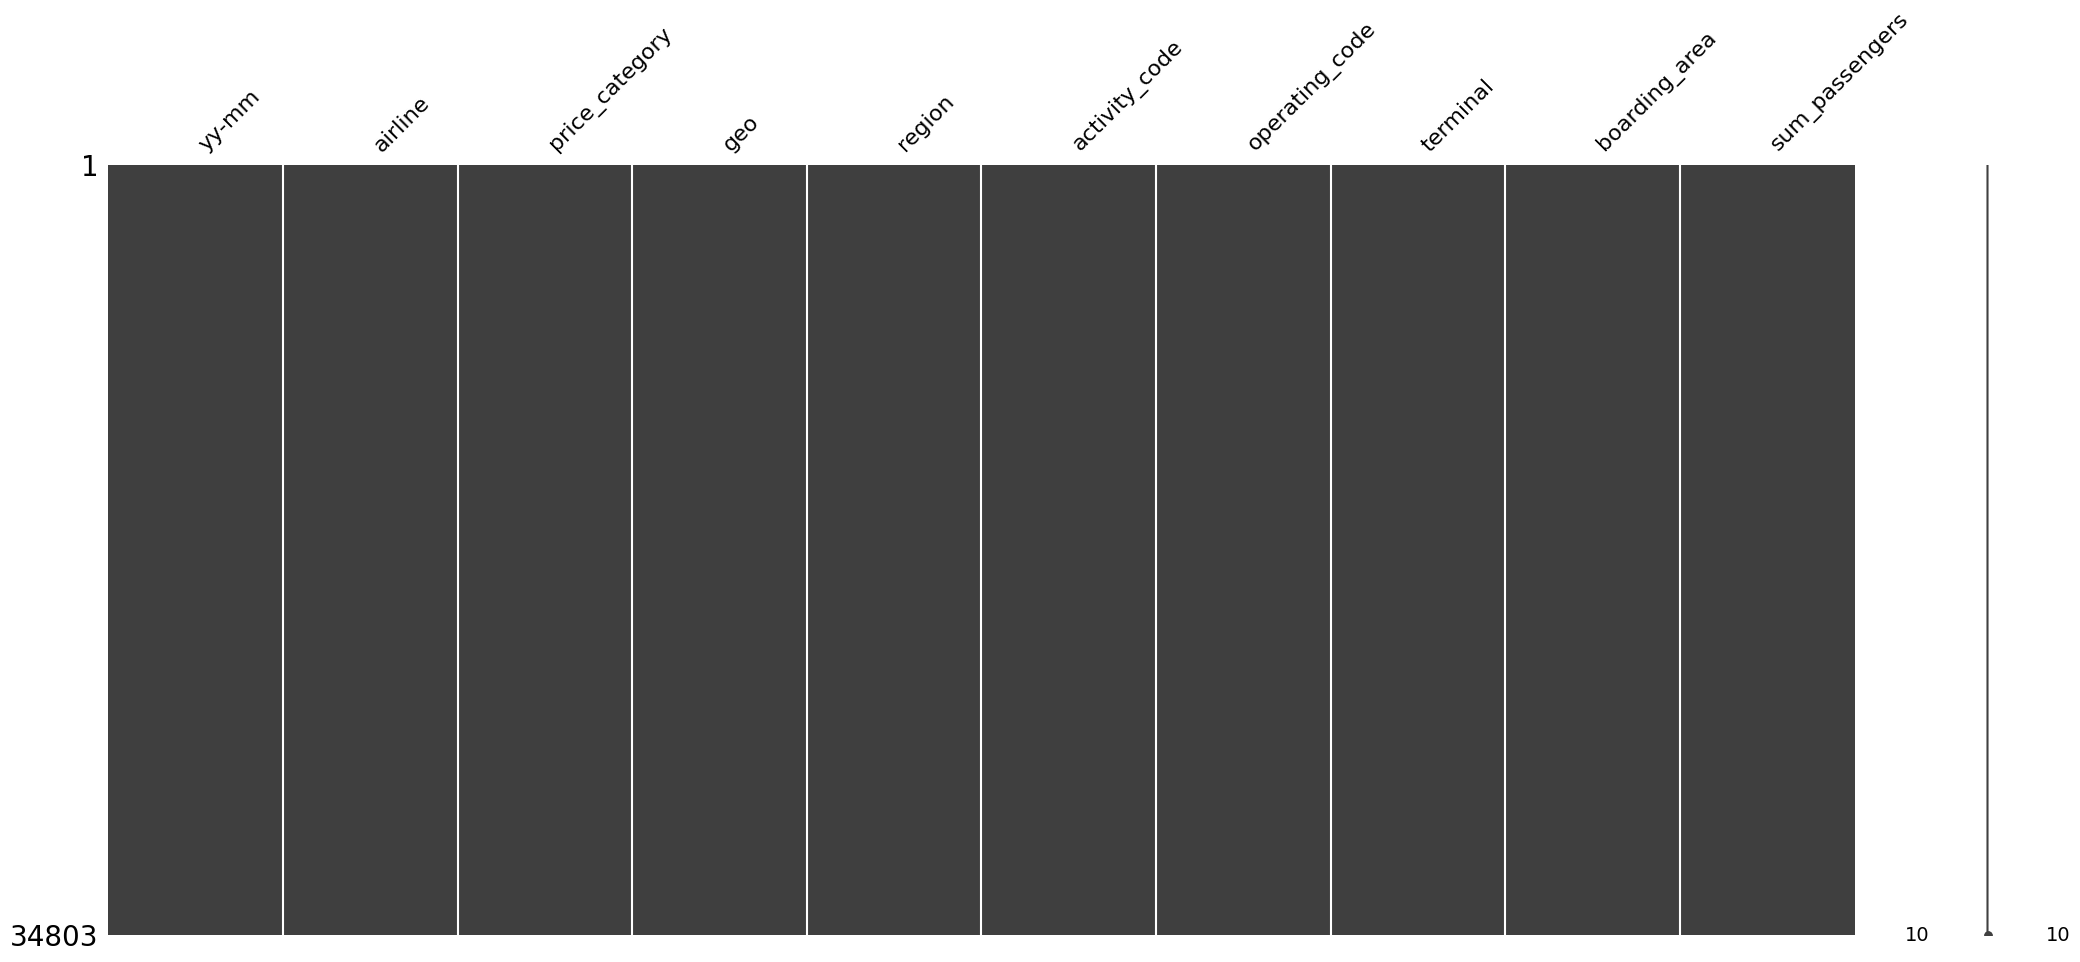

In [63]:
msno.matrix(final_df)

I made a mistake in the presentation. Below is actually the counting of records, not the count of passengers.

But this is the count of passengers based on some combinations of features.

In the presentation, we wanted to use these as the "additional" columns to be merged with the main dataset. However, after further inspectation, it is better that we simply use this as the main dataframe because it allows us to predict the next calendar month's passenger count for each airline.

Fill in the ? below.

In [65]:
data.columns

Index(['activity_period', 'start_date', 'airline', 'operating_code',
       'published_airline', 'published_code', 'geo', 'region', 'activity_code',
       'price_category', 'terminal', 'boarding_area', 'passengers',
       'data_as_of', 'data_load_time', 'yy-mm', 'year', 'month', 'index',
       'record_weekday', 'days_in_month', 'yrs_since_2020'],
      dtype='object')

Our prediction now becomes

```
sum_passengers
```

Which is measured on a yy-mm basis.



#### don't forget to modify the code before to include other changes you made for large values in the dataset

In [ ]:
"yrs_since_2020", "days_in_month", "record_weekday"

In [129]:
specific_cols = ["start_date", "airline", "price_category", "geo", "region", "activity_code", "operating_code", "terminal", "boarding_area"]

In [131]:
data["price_category"] = data["pricing"]

In [133]:
final_df = data\
                .groupby(specific_cols)\
                ['passengers']\
                .agg(['sum'])\
                .rename(columns=lambda colname: str(colname)+'_passengers')\
                .reset_index()

In [134]:
# Add features to include: counting by different features
for col in specific_cols:
    final_df["count_by_"+col] = final_df[col].replace(final_df.groupby([col]).size().to_dict())

In [135]:
# Some additional time features
final_df['year'] = pd.to_datetime(final_df['start_date']).dt.year
final_df['month'] = pd.to_datetime(final_df['start_date']).dt.month
final_df['record_weekday'] = pd.to_datetime(final_df['start_date']).dt.day_of_week
final_df['days_in_month']  = pd.to_datetime(final_df['start_date']).dt.days_in_month

# investigate into 2020, which was an anomaly
final_df["yrs_since_2020"] = pd.to_datetime(final_df['start_date']).dt.year - 2020

In [100]:
final_df.head()

start_date                                  airline price_category  \
0  1999/07/01                             ATA Airlines       Low Fare   
1  1999/07/01                             ATA Airlines       Low Fare   
2  1999/07/01                             ATA Airlines       Low Fare   
3  1999/07/01  Aeroflot Russian International Airlines          Other   
4  1999/07/01  Aeroflot Russian International Airlines          Other   

             geo  region   activity_code operating_code    terminal  \
0       Domestic      US        Deplaned             TZ  Terminal 1   
1       Domestic      US        Enplaned             TZ  Terminal 1   
2       Domestic      US  Thru / Transit             TZ  Terminal 1   
3  International  Europe        Deplaned  not_specified  Terminal 2   
4  International  Europe        Enplaned  not_specified  Terminal 2   

  boarding_area  sum_passengers  count_by_start_date  count_by_airline  \
0             B         31432.0                  137               271   
1             B         31353.0                  137               271   
2             B          2518.0                  137               271   
3             D          1324.0                  137               114   
4             D          1198.0                  137               114   

   count_by_price_category  count_by_geo  count_by_region  \
0                     3824         12499            12499   
1                     3824         12499            12499   
2                     3824         12499            12499   
3                    31295         22620             5822   
4                    31295         22620             5822   

   count_by_activity_code  count_by_operating_code  count_by_terminal  \
0                   16411                      271               6461   
1                   16602                      271               6461   
2                    2106                      271               6461   
3                   16411                      316               2288   
4                   16602                      316               2288   

   count_by_boarding_area  year  month  record_weekday  days_in_month  \
0                    3718  1999      7               3             31   
1                    3718  1999      7               3             31   
2                    3718  1999      7               3             31   
3                    2288  1999      7               3             31   
4                    2288  1999      7               3             31   

   yrs_since_2020  
0             -21  
1             -21  
2             -21  
3             -21  
4             -21

Fill Missing Values

<Axes: >

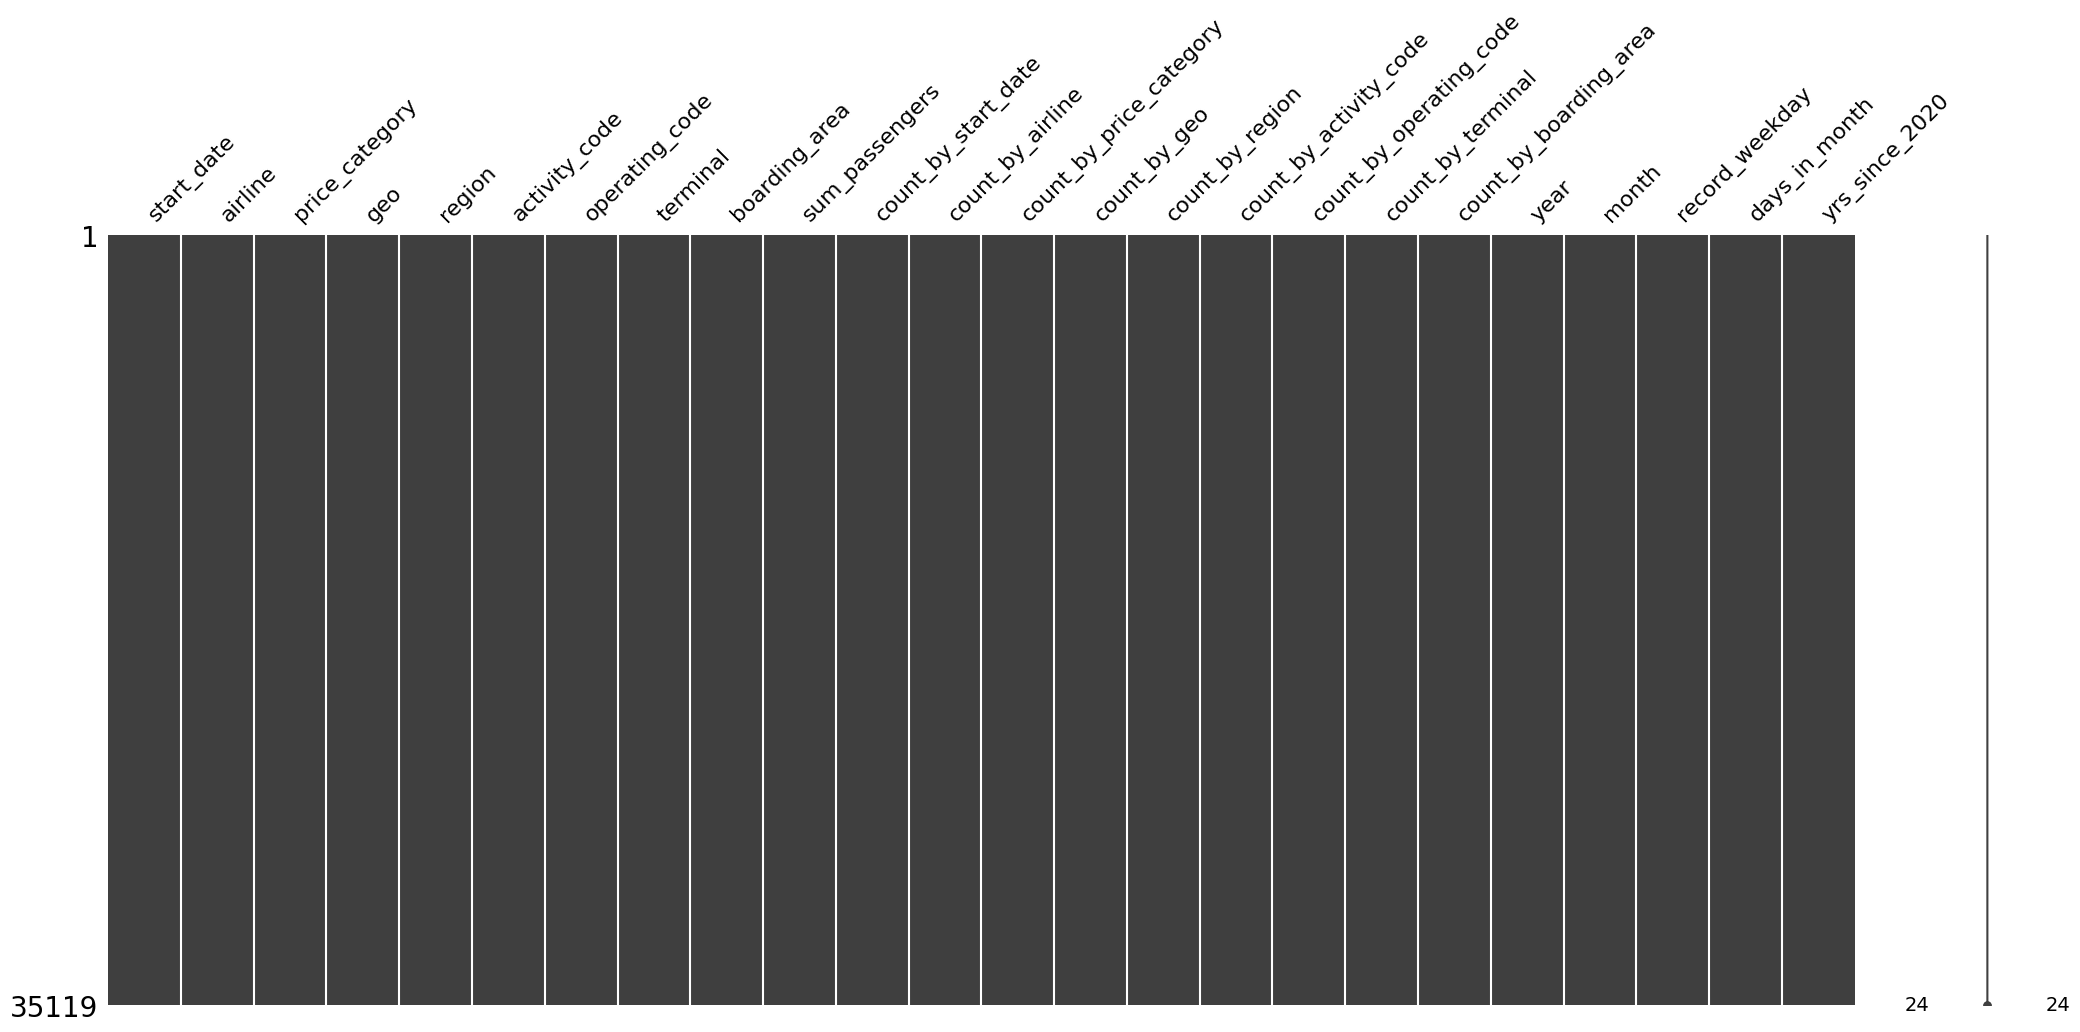

In [136]:
import missingno as msno
%matplotlib inline

msno.matrix(final_df)

### Feature Engineering

Feature engineering is the process of using domain and statistical knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. Feature engineering can be considered as applied machine learning itself.

There are generally 3 types of variables: datetime (a special type that

Choose 2 of your choice and apply to variables where there is text. The goal is to convert text into numbers.

one hot encoding

frequency encoding

target encoding

ordinal encoding

binary encoding

feature hashing

weight of evidence


#### Most relevant:

1. `One Hot Encoding` is great for variables with 2 unique values (ie. encode "a": 0, "b": 1) What variables in our dataset fits this description?  

2. `Target Encoding` is a great way to do it, but it does make the variables very dependent on "passengers" where the dependency might not be there. Tip: Select variables based on the correlation matrix (how might you take this info to decide what variables to do target encoding?)

3. `Probability ratio` is another good encoding technique.
It replaces each unique value with the probability of it showing up in the dataset. Tip: Select variables that aren't too balanced (ie: if we are talking about "letter". Suppose 33.3% of "a", "b", and "c" show up, then probability doesn't differentiate anything.
How do you know which variables are best for this method? Data visualization!

4. `Ordinal encoding` is for variables with clear ranking among its unique values (ie: "high", "medium", "low") so replacing them with ("high": 2, "medium": 1, "low": 0) makes sense. But we don't have such variables in our dataset, except `price_category`, which can be done with one-hot-encoding.

5. One interesting alternative is `binning`. You can separate "passengers" into different ranges of evenly spaced values and basically make it an ordinal encoding problem. Now you have a clear ranking system:
ie. "high_passenger_flight", then "medium", then "low". How many bins are suitable? You can also experiment with alternative spacing for bins (how about binning based on z-scores or some other statistical measure, instead of even spacing)? What other variables might be applicable?

6. Time-series specific `feature engineering` (based on "passengers")
In our meeting, we went over `df.passengers.diff().fillna(0)` function to subtract the current "passengers" value with the previous value to de-trend. You can do it here too. Name it lag1. More lags? How many is up to discussion. Also experiment with larger lags. (ie subtract passenger count for "2023-01" vs "2022-01". Don't forget to add `.fillna(0)` to get rid of Null values created by subtracting non-existent previous values.   
Another idea is "rolling avarages" or perhaps "rolling weighted averages". Goolge these terms.
What other time-series based variables can you make here?

Tips for clarity:
1. A "unique value" means just that: a unique value. If a variable called "letter" has 2 possible values "a" and "b", then "a" and "b" each is a unique value of "letter".
2. When you Google, different sources will have different names. They might say "levels" to mean "unique values" and "features" to mean "variables", hence "feature engineering", which really is "variable engineering".
3. "Encoding" specifically means converting text——>numbers. "Feature Engineering" is an umbrella term that INCLUDES "encoding" but also includes other manipulations of variables (ie. making a lag variable by doing subtractions)
4. "object"="categorical"="texual". The 3 terms describe the same type of variable.  
4. When you encode, there are libraries written by other people that make you do .fit() and then .transform(). This is a valid way to do it. However, try to see if you can manually map values by first creating a dictionary, then creating a map.    

Challenge #1: For #2 and #3 above, is there a way for you to base the average passenger count (or probability) on yy-mm (year and month variable) for unique values of your chosen variables?

Challenge #2: Instead of yy-mm, other candidates can be year (1999-2023, all months inclusive for each year) or month (Jan-Dec, all years inclusive for each month) Consider the pros and cons of each and decide. What about both?

Tip: There are many ways to do the challenges above. Some harder, some simpler. Knowing ways to break this down into steps.

Reference resources here. Also check out other websites about feature engineering:

https://towardsdatascience.com/encoding-categorical-features-21a2651a065c
https://pbpython.com/categorical-encoding.html
https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

It's useful to use the following functions:

(1) df.groupby([columns]).to_dict() to make a dictionary

(2) df.column.replace(dictionary from (1))

In [94]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35119 entries, 0 to 35118
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   start_date                      35119 non-null  object 
 1   airline                         35119 non-null  object 
 2   price_category                  35119 non-null  object 
 3   geo                             35119 non-null  object 
 4   region                          35119 non-null  object 
 5   activity_code                   35119 non-null  object 
 6   operating_code                  35119 non-null  object 
 7   terminal                        35119 non-null  object 
 8   boarding_area                   35119 non-null  object 
 9   sum_passengers                  35119 non-null  float32
 10  count_by_start_date             35119 non-null  int64  
 11  count_by_airline                35119 non-null  int64  
 12  count_by_price_category         

Add airline total years of operation

In [137]:
final_df.year.unique()

array([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023])

In [147]:
from collections import Counter as counter

# max and min
max = final_df.groupby(["airline"])["year"].max().to_dict()
min = final_df.groupby(["airline"])["year"].min().to_dict()

In [ ]:
operation_years = {key: max[key] - min.get(key, 0) + 1 for key in min.keys()}
final_df["airline_yrs"] = final_df.airline.replace(operation_years)

Replace Price categories with one hot encoding

In [152]:
final_df["pricing"] = np.where(final_df.price_category == "Other", 1, 0)
del final_df["price_category"]
# another way:
# .replace({"":, "":})

The idea is to use conditional probability here

In [91]:
final_df.columns

Index(['start_date', 'airline', 'price_category', 'geo', 'region',
       'activity_code', 'operating_code', 'terminal', 'boarding_area',
       'sum_passengers', 'count_by_start_date', 'count_by_airline',
       'count_by_price_category', 'count_by_geo', 'count_by_region',
       'count_by_activity_code', 'count_by_operating_code',
       'count_by_terminal', 'count_by_boarding_area', 'year', 'month',
       'record_weekday', 'days_in_month', 'yrs_since_2020',
       'passengers_per_airline'],
      dtype='object')

In [164]:
def year_based_mean_encoding(data, encode_col, time="start_date"):
  # initialize with 0's
  data[f"passengers_per_{encode_col}"] = np.zeros(data.shape[0])

  for ym in data[time].unique():
    # first filter by yy-mm, then do a groupby for replacing, which is a much simpler.
    replace_dict = data[data[time]==ym].groupby([encode_col])["sum_passengers"].mean().to_dict()
    # apply the dict mapping to only specific parts of the data
    data.loc[data[time]==ym, [f"passengers_per_{encode_col}"]] = data[encode_col].replace(replace_dict)
  # fill NA values with 0
  data[f"passengers_per_{encode_col}"].fillna(0, inplace=True)
  return data

In [165]:
final_df = year_based_mean_encoding(final_df, "airline")
final_df = year_based_mean_encoding(final_df, "geo")
final_df = year_based_mean_encoding(final_df, "region")
final_df = year_based_mean_encoding(final_df, "activity_code")
final_df = year_based_mean_encoding(final_df, "operating_code")
final_df = year_based_mean_encoding(final_df, "terminal")
final_df = year_based_mean_encoding(final_df, "boarding_area")
final_df = year_based_mean_encoding(final_df, "pricing")

In [170]:
def year_based_probability_encoding(data, encode_col, time="start_date"):

  # initialize with 0's
  data[f"{encode_col}_ratio"] = np.zeros(data.shape[0])

  for ym in data[time].unique():
    # first filter by yy-mm, then do a groupby (based on yymm) for replacing, which is a much simpler.
    replace_dict = data[data[time]==ym].groupby([encode_col]).size() / data[data[time]==ym].shape[0]
    # apply the dict mapping to only specific parts of the data
    data.loc[data[time]==ym, [f"{encode_col}_ratio"]] = data[encode_col].replace(replace_dict)
  # fill NA values with 0
  data[f"{encode_col}_ratio"].fillna(0, inplace=True)
  return data

In [171]:
final_df = year_based_probability_encoding(final_df, "operating_code")
final_df = year_based_probability_encoding(final_df, "activity_code")
final_df = year_based_probability_encoding(final_df, "geo")
final_df = year_based_probability_encoding(final_df, "region")
final_df = year_based_probability_encoding(final_df, "airline")
final_df = year_based_probability_encoding(final_df, "terminal")
final_df = year_based_probability_encoding(final_df, "boarding_area")
final_df = year_based_mean_encoding(final_df, "pricing")

Delete categorical / texual / object variables (columns)

In [172]:
del specific_cols[2]
del specific_cols[0]
for c in specific_cols:
  del final_df[c]

In [173]:
del final_df["start_date"]

save start_date as times for later use

In [176]:
final_df["yrs_since_2020"] = final_df["yrs_since_2020"].astype("int32")

In [178]:
# Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [179]:
reduce_mem_usage(final_df)

Mem. usage decreased to  2.41 Mb (71.0% reduction)


sum_passengers  count_by_start_date  count_by_airline  \
0             31432.0                  137               271   
1             31353.0                  137               271   
2              2518.0                  137               271   
3              1324.0                  137               114   
4              1198.0                  137               114   
...               ...                  ...               ...   
35114          7173.0                  142               550   
35115          1965.0                  142               233   
35116          1963.0                  142               233   
35117          4599.0                  142                12   
35118          5347.0                  142                12   

       count_by_price_category  count_by_geo  count_by_region  \
0                         3824         12499            12499   
1                         3824         12499            12499   
2                         3824         12499            12499   
3                        31295         22620             5822   
4                        31295         22620             5822   
...                        ...           ...              ...   
35114                    31295         22620             5822   
35115                    31295         22620             3247   
35116                    31295         22620             3247   
35117                    31295         22620             7562   
35118                    31295         22620             7562   

       count_by_activity_code  count_by_operating_code  count_by_terminal  \
0                       16411                      271               6461   
1                       16602                      271               6461   
2                        2106                      271               6461   
3                       16411                      316               2288   
4                       16602                      316               2288   
...                       ...                      ...                ...   
35114                   16602                      550              21714   
35115                   16411                      233              21714   
35116                   16602                      233              21714   
35117                   16411                       12              21714   
35118                   16602                       12              21714   

       count_by_boarding_area  year  month  record_weekday  days_in_month  \
0                        3718  1999      7               3             31   
1                        3718  1999      7               3             31   
2                        3718  1999      7               3             31   
3                        2288  1999      7               3             31   
4                        2288  1999      7               3             31   
...                       ...   ...    ...             ...            ...   
35114                   12063  2023     11               2             30   
35115                   12063  2023     11               2             30   
35116                   12063  2023     11               2             30   
35117                   12063  2023     11               2             30   
35118                   12063  2023     11               2             30   

       yrs_since_2020  airline_yrs  pricing  passengers_per_airline  \
0                 -21           10        0            21767.666016   
1                 -21           10        0            21767.666016   
2                 -21           10        0            21767.666016   
3                 -21            6        0             1261.000000   
4                 -21            6        0             1261.000000   
...               ...          ...      ...                     ...   
35114               3           25        0             7201.000000   
35115               3           20     

In [ ]:
# numeric = [c for c in final_df.columns if c not in specific_cols]

"""
for col in ['Fee', 'Discount']:
    df[col] = df[col].astype('float')
"""

<Axes: >

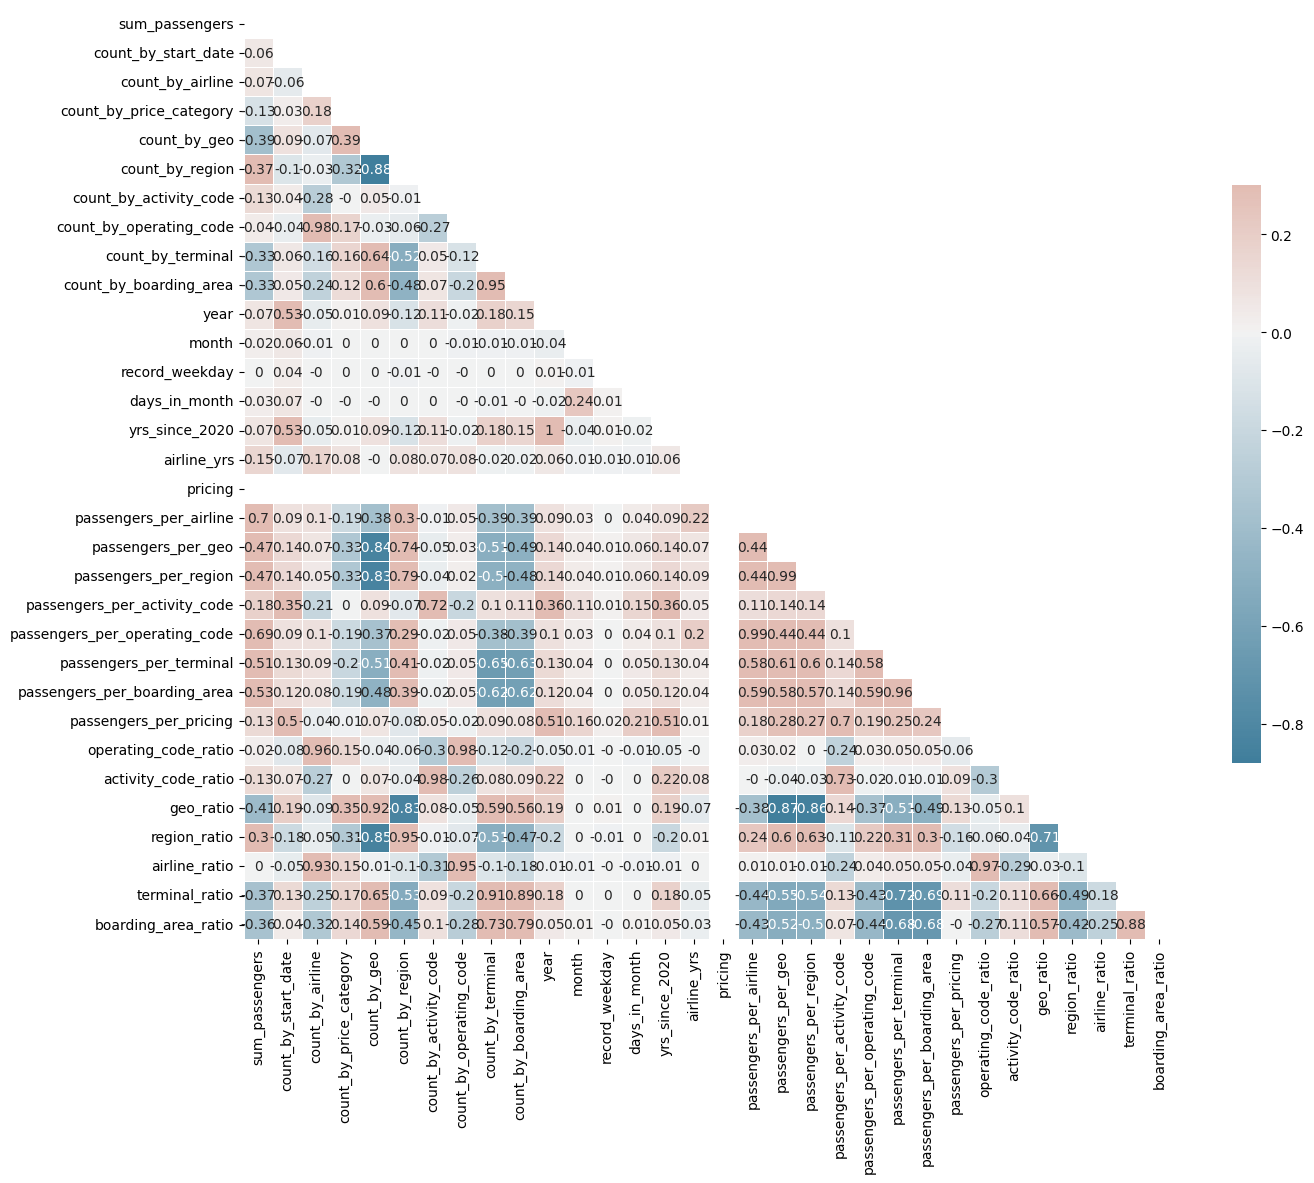

In [180]:
# Compute the correlation matrix
corr = final_df.corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### ML model

Train, val, test splitting

Fill in ?

In [ ]:
# Set a year
# train_selector = master_df.year < ? # decide on a year

# x_train
x_train = master_df[train_selector].drop(["passengers"],axis=1)

# apply np.log1p() (log(1+x)) to passengers count, to correct for high skewness
y_train = master_df[train_selector]['passengers'].apply(np.log1p)

# convert it back to original scale and check
y_train_original = y_train.apply(np.exp) - 1

# do the same as above, but split x_train into train and val (one for training, one for evaluation)
# test_selector = master_df.year >= ? # decide on a year

x_test, y_test = master_df[test_selector].drop(["passengers"],axis=1), master_df[test_selector]['passengers'].apply(np.log1p)

y_test_original = y_test.apply(np.exp) - 1

print('Training dataset dimensions')
print('- x_train:', x_train.shape)
print('- y_train:', y_train.shape)

#### Metrics

What evaluation metric might we use for a model?

https://www.enjoyalgorithms.com/blog/evaluation-metrics-regression-models

Work with your team to make this evaluation metric.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Idea:
    1. subtraction: (y_true-y_pred).
    We are subtracting an array of numbers from another, element-wise.
    2. divide the result by the y_true array
    3. take the absolute value of the array's result
    4. take the mean of the result and return it as a percentage (multiply by 100)
    """
    # y_true, y_pred = np.array(y_true), np.array(y_pred)
    # middle steps...
    # result = ?
    return result

Search up:

https://www.enjoyalgorithms.com/blog/evaluation-metrics-regression-models

And see if you can adopt one of the metrics or potentially change it.

Mean Squared Error (MSE) is EXTREMELY popular among statisticians but it makes errors very big, because we are squaring the error terms (the idea is, if you add up positive and negative errors, you will end up around 0, hence why we take the square of error terms). Think of ways to scale MSE down with a mathematical funtion, or eliminate the effect of adding positive and negative errors.     

Root Mean Squared Error

In [ ]:
def RMSLE(y_true, y_pred):
  """
  1. take the mean squared error of the log of the (y_true-y_pred)
  2. take the square root of the array
  use numpy (np) functions for mathematical operations
  """
  # y_true, y_pred = np.array(y_true), np.array(y_pred)
  # middle steps...
  # result = ?
  return result

#### Splitting Data

First, try once without cross-validation

Fill in ?

In [ ]:
# Dave's chosen model (might as well be his favorite)

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

To take advantage of time series, search up

```
time series splitting
```

for cross-validation



In [ ]:
"""
data.set_index('yy-mm', inplace=True)
data.sort_index(inplace=True)
"""

Fill in ?

In [ ]:
#y = ? # passengers variable
#x = ? # everything else

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 3)

In [ ]:
for train_index, test_index in tss.split(X):
    x_train, x_test = x.iloc[train_index, :], x.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#### Hyperparameter Tuning

**Hyperparameter** is a parameter that governs how the algorithm trains to learn the relationships. The values are set before the learning process begins.

**Hyperparameter tuning** refers to the automatic optimization of the hyper-parameters of a ML model.

Fill in ?s below

In [ ]:
# Define the model
# model = ?(random_state=0, n_jobs=-1)

# Define the parameters gird
param_grid = {
#    '?'     : [],            # range of values
#    '?'     : [],            # range of values
#    '?'     : [],            # range of values
#    '?'     : [],            # default: .1
}

# run grid search
grid = GridSearchCV(model, param_grid=param_grid, refit = True, verbose = 3, n_jobs=-1, cv = 3)

# fit the model for grid search
grid.fit(x_train, y_train)

In [ ]:
# Best parameter after hyper parameter tuning
print(grid.best_params_)

# Moel Parameters
print(grid.best_estimator_)

regressor = grid.best_estimator_

### Feature Importance



It is condusive for ML to compare variables in terms of how useful they are

In [ ]:
feature_importance_df = pd.DataFrame({'feature' : x_train.columns, 'importance' : model.feature_importances_ })
feature_importance_df

Write a function that ranks feature importance from high to low, and plot this

###################

If time is not an issue, don't settle for 1 model. Try a couple.

Catboost regressor, Adaboost regressor, decision-tree regressor, or even polynomial regression are all valid models.

Also be sure to do a good amount of feature engineering to find a good combination of features. Be sure to always check against the metrics such as RMSLE or MAPE (mean average percentage error), defined above.

Which ML model, what metrics, and what hyperparameters are up to you